### FLiBe Simple

In [1]:
import openmc
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Helper functions
def logspace_per_decade(start, stop, pts_per_decade):
    """
    Returns values from 'start' to 'stop' so that each factor-of-10
    interval contains 'pts_per_decade' points (including its first endpoint).
    Might be a little off if 'stop' isn't precisely at a decade, ex. 20e6 eV

    example: 10 points per decade from 1e-5 → 2e7
    grid = logspace_per_decade(1e-5, 20e6, pts_per_decade=10)
    for i in grid:
        print(np.log10(i))
    # print(np.log10(i) for i in grid)
    """
    log_start = np.log10(start)
    log_stop  = np.log10(stop)
    total_decades = log_stop - log_start
    # how many intervals of size 1 decade we need, as a float
    total_steps = total_decades * pts_per_decade
    # +1 so that we include the very last point at `stop`
    npts = int(np.ceil(total_steps)) + 1
    return np.logspace(log_start, log_stop, num=npts)

Neutronics codes like MCNP and OpenMC define some model on an input deck or file. This input has three main components: Materials, Geometry, and Problem Settings. 
### Materials
We define the composition . Each `Material` class is given some density, temperature, and isotopic composition. Materials can be (homogeneously) mixed to create a new material. The materials we actually use in the problem are then collected into the `Materials` class and exported as an `.xml` file.

In [3]:
# User specifications
DENSITY_FLIBE = 1.8 # usu 1.8-2.0 g/cc
ENRICH_LI = 20
MOL_LIF, MOL_BEF2 = 0.66, 0.34
TEMP = 900 # K

VOL = 342 * 100e3 # cm3
M_U, M_FLIBE = 0.0181*20/50, 1 # in Ball et al. --EZ
MR_U, MR_FLIBE = M_U / (M_U + M_FLIBE), M_FLIBE / (M_U + M_FLIBE) # mol ratios

""" 
MATERIALS
  OpenMC automatically normalizes the fraction of each element in material (like MCNP)
  but the fractions in 'mix_materials' MUST add up to 1
"""
flibe = openmc.Material(name="FLiBe", temperature=TEMP)
flibe.set_density('g/cm3', DENSITY_FLIBE) 
flibe.add_element('Li',MOL_LIF,'ao',ENRICH_LI,'Li6','wo')
flibe.add_element('Be',MOL_BEF2,'ao')
flibe.add_element('F',(MOL_LIF+2*MOL_BEF2),'ao')

uranium = openmc.Material(name="U",temperature=TEMP)
uranium.add_element('U',100,'ao',0.7204)
# uranium.add_nuclide('U238',100) --ezoccoli

mix = openmc.Material.mix_materials([flibe, uranium], [MR_FLIBE, MR_U], 'ao') # 
mix.temperature = 900

# print(flibe.get_nuclide_atom_densities()) # Returns one or all elements in the material and their atomic densities in units of atom/b-cm
# print(f"ppark checksum for FLiBe 1.8 g/cc, 0.64 mol LiF, 0.33 mol BeF2:")
# print(f"  'Li6': 0.00489411249582549, 'Li7': 0.016783401745946593, 'Be9': 0.011167204306367438, 'F19': 0.04401192285450695")

materials = openmc.Materials([mix])
# materials.cross_sections = '/opt/openmc_data/endfb-viii.0-hdf5/cross_sections.xml' # use this on zotac --ppark
materials.cross_sections = '/mnt/c/openmc/data/endfb-viii.0-hdf5/cross_sections.xml' # use this on zotac --ppark
# os.makedirs("./xml/", exist_ok=True) 
# materials.export_to_xml("./xml/materials.xml") # don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

#### Geometry
For our simple case suppose we make a 1 m$^3$ cube with reflective surfaces of homogeneous FLiBe. We define a cubical cell defined by 6 planes, and place this cell in the "universe." (Alex actually suggested switching from 1 cm side to 1 m side because if the geometry is too small we'll spend too much computational time calculating neutron reflections.) Then, like the materials, we export these definitions to `geometry.xml`.

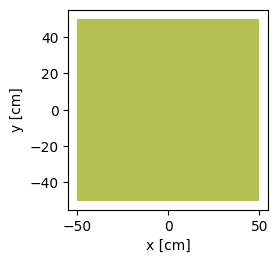

In [4]:
""" GEOMETRY
"""
xmin = openmc.XPlane(-50, boundary_type='reflective')
xmax = openmc.XPlane( 50, boundary_type='reflective')
ymin = openmc.YPlane(-50, boundary_type='reflective')
ymax = openmc.YPlane( 50, boundary_type='reflective')
zmin = openmc.ZPlane(-50, boundary_type='reflective')
zmax = openmc.ZPlane( 50, boundary_type='reflective')

region = +xmin & -xmax & +ymin & -ymax & +zmin & -zmax
cell = openmc.Cell(fill=mix, region=region)
root_univ = openmc.Universe(cells=[cell])

root_univ.plot(width=(110, 110), origin=(0.0, 0.0, 0.1))

geometry = openmc.Geometry(root_univ)
# geometry.export_to_xml("./xml/geometry.xml") # don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

#### Settings
Here we define the other settings for our problem. 

In [5]:
""" 
SETTINGS
"""
settings = openmc.Settings()

""" Tallies
"""
energy_filter = openmc.EnergyFilter(logspace_per_decade(1e-5, 20e6, 10)) # helper function 'logspace_per_decade' from above
# energy_filter = openmc.EnergyFilter.from_group_structure('CCFE-709')
#   These have extra bins in key energy ranges. A full list of energy structures is available here: --ppark 2025-06-27
#   https://github.com/openmc-dev/openmc/blob/6254be37582e09acff038f5656332b89e53e4eae/openmc/mgxs/__init__.py#L50-L420

# (Uranium) Tally
U_tally = openmc.Tally(name='U tally')
U_tally.scores = ['(n,gamma)','fission', 'elastic'] # specific names required
U_tally.nuclides = ['U238', 'U235']
U_tally.filters = [energy_filter]

# (Li) Tally
Li_tally = openmc.Tally(name='Li tally')
Li_tally.scores = ['(n,gamma)','(n,t)', 'elastic'] # specific names required
Li_tally.nuclides = ['Li6', 'Li7']
Li_tally.filters = [energy_filter]

# (F) Tally
F_tally = openmc.Tally(name='F tally')
F_tally.scores = ['(n,gamma)', 'elastic'] # specific names required
F_tally.nuclides = ['F19']
F_tally.filters = [energy_filter]

# (Be) Tally
Be_tally = openmc.Tally(name='Be tally')
Be_tally.scores = ['(n,gamma)','(n,2n)', 'elastic'] # specific names required
Be_tally.nuclides = ['Be9']
Be_tally.filters = [energy_filter]

tallies = openmc.Tallies([U_tally, Li_tally, F_tally, Be_tally])
# tallies.export_to_xml("./xml/tallies.xml") --don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

""" 
Source
  Isotropic 14.07 MeV point source at center of cube
"""
source = openmc.IndependentSource()
source.space = openmc.stats.Point((0,0,0))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([14.07e6], [1.0])
settings.source = source

"""
Run type
"""
settings.run_mode = 'fixed source'
settings.particles = int(1e5)
settings.generations_per_batch = 10
settings.batches = 100
settings.inactive = 5

# settings.export_to_xml("./xml/settings.xml") # don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

Patrick: I changed `model.export_to_xml()` to `model.export_to_model_xml` so that only 1 xml is printed with all of the information, instead of 3 separate xml files.

In [6]:
model = openmc.model.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./model/") 

Run OpenMC

In [7]:
results_NSlow = model.run(cwd="./model/") # cwd="./xml")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [43]:
# open the results file
with openmc.StatePoint(results_NSlow) as sp:
    U_tally = sp.get_tally(name='U tally')
    Li_tally = sp.get_tally(name='Li tally')
    F_tally = sp.get_tally(name='F tally')
    Be_tally = sp.get_tally(name='Be tally')

# Here I suppose our reactions of interest are U235(n,f), U238(n,f), U238(n,g), Li6(n,t) --ppark 2025-06-28
U235_fission_binned = U_tally.get_values(scores=['fission'],nuclides=['U235']).flatten()
U238_fission_binned = U_tally.get_values(scores=['fission'],nuclides=['U238']).flatten()
U238_gamma_binned   = U_tally.get_values(scores=['(n,gamma)'],nuclides=['U238']).flatten()
Li6_tritium_binned  = Li_tally.get_values(scores=['(n,t)'],nuclides=['Li6']).flatten()

E_list = logspace_per_decade(1e-5, 20e6, 10)[:-1]

U235_fission = sum(U235_fission_binned)
U238_fission = sum(U238_fission_binned)
U238_gamma   = sum(U238_gamma_binned)
Li6_tritium  = sum(Li6_tritium_binned)

print(f"total U235 fission {U235_fission} \n" \
      f"      U238_fission {U238_fission} \n" \
      f"      U238_gamma   {U238_gamma}   \n" \
      f"      Li6_tritium  {Li6_tritium}  " )

total U235 fission 0.0020489939197978818 
      U238_fission 0.020663804938590748 
      U238_gamma   0.05058236820676573   
      Li6_tritium  1.1023461939109425  


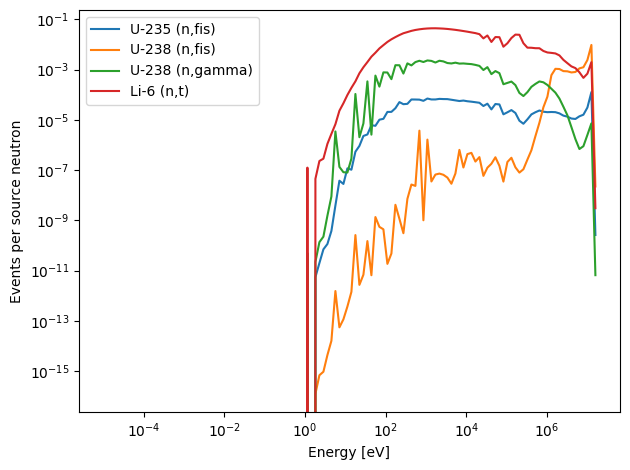

In [49]:
plt.figure()
plt.plot(E_list, U235_fission_binned, label='U-235 (n,fis)')
plt.plot(E_list, U238_fission_binned, label='U-238 (n,fis)')
plt.plot(E_list, U238_gamma_binned,   label='U-238 (n,gamma)')
plt.plot(E_list, Li6_tritium_binned,  label='Li-6 (n,t)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [eV]')
plt.ylabel('Events per source neutron')
plt.legend()
plt.tight_layout()
plt.show()

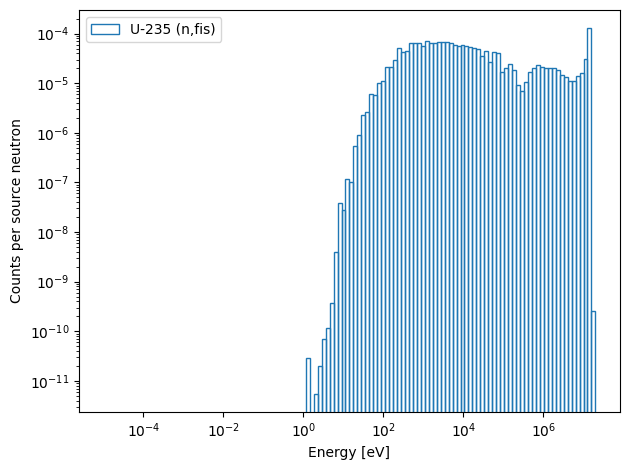

In [52]:
plt.figure()
widths = np.diff(logspace_per_decade(1e-5, 20e6, 10))
plt.bar(
    E_list, U235_fission_binned,
    width=widths, align='edge', fill=False, edgecolor='C0', label='U-235 (n,fis)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [eV]')
plt.ylabel('Counts per source neutron')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:


# Calculate pdf for source energies
rxn, bin_edges = np.histogram(ufis, energies, density=True)
print(rxn)
print(bin_edges)

# Plot source energy PDF
plt.semilogx(energies[:-1], rxn, drawstyle='steps')
plt.xlabel('Energy [eV]')
plt.ylabel('Events per neutron')